# Task Assignment Resilience Analysis

In [1]:
%reload_ext autoreload
%autoreload 2
from multiprocessing import Pool
from matplotlib.cm import viridis
from matplotlib.pyplot import contourf, hist2d
from matplotlib.ticker import PercentFormatter
from numpy import linspace
from numpy.random import default_rng
from pandas import concat
from tqdm import tqdm
from taadaptivity.model import TaskModel


# Parameters
RNG = default_rng(98820557)
NUM_REPS = 500
SIGMAS = linspace(0, 22, 50)
T_MAX = 1000
PARAMS = {"num_agents": 50, "t_new": 10, "loc": 50,
          "sigma": 8.5, "performance": 0.01, "init_task_count": 15}
N_CORES = 10


# Helpers
def sample_seed(rng, size = None):
    """Use the given RNG to sample new seeds for other numpy RNGs."""
    return rng.integers(2**63, size = size)
    # TODO: Turn this into a generator that samples unique random numbers.

## Tasks per Agent over Time

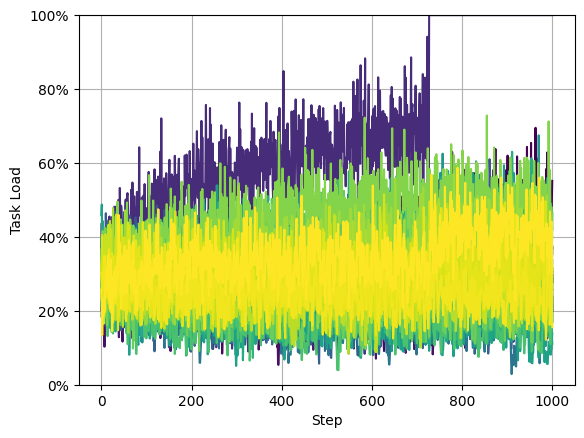

In [2]:
# Run ABM
abm = TaskModel(PARAMS, max_steps = T_MAX, seed = sample_seed(RNG))
abm.run_model()

# Plot measured agent load
#     .unstack transforms into rows=timestep, cols=AgentIDs, and .line plots
#     columns as separate lines.
agent_df = abm.datacollector.get_agent_vars_dataframe()
axis = agent_df.unstack().plot.line(cmap = viridis, ylabel = "Task Load", ylim = (0, 1),
                                    legend = False, grid = True)
axis.yaxis.set_major_formatter(PercentFormatter(1))  # see: https://stackoverflow.com/a/36319915

## Agent Failure vs. Heterogeneity Plot 

2d-Histogram:
- y: Failed Agents
- x: Agent Heterogeneity $\sigma$
- num_agents: 100
- Plot: 1000 steps, 500 simulations per sigma, sigma in `np.linspace(0, 22, 50)`.

In [ ]:
# Simulation helpers
def abm_factory(num_reps, num_steps, sigmas, fixed_params, rng):
    """Yield the kwargs for TaskModel.__init__ to implement the provided parameter sweep."""
    for sigma in sigmas:
        for _ in range(num_reps):
            params = fixed_params.copy()
            params["sigma"] = sigma
            yield {"params": params, "max_steps": num_steps, "seed": sample_seed(rng)}


def run_model(taskmodel_kwargs):
    """Constructs a TaskModel, runs it, and then returns measurements from the run.
    
    Args:
        taskmodel_kwargs: A dictionary with the arguments to TaskModel.__init__.
    
    Returns:
        A Pandas DataFrame with rows corresponding to time and with columns as:
        "Step", "Fraction_Failed", "Matrix_Entropy", "sigma", and "seed". The
        columns "sigma" and "seed" are simply the respective input values
        repeated across rows. This enables to distinguish parameter settings
        when joining DataFrames across several runs.
    """
    # Run model
    abm = TaskModel(**taskmodel_kwargs)
    abm.run_model()
    
    # Return dataframe
    measurements = abm.datacollector.get_model_vars_dataframe().\
        loc[["Fraction_Failed", "Matrix_Entropy"]].\
        assign(sigma = taskmodel_kwargs["params"]["sigma"], seed = taskmodel_kwargs["seed"]).\
        reset_index(names = "Step")
        # reset_index turns the step-ids (the index) into a column to avoid merging issues later.
    return measurements

In [ ]:
# Simulate ABMs behind figure
with Pool(N_CORES) as pool:
    param_list = list(abm_factory(num_reps = NUM_REPS, num_steps=T_MAX, sigmas = SIGMAS,
                                  fixed_params = PARAMS, rng = RNG))
    abm_df = tqdm(pool.imap_unordered(run_model, param_list),
                  total = len(param_list))

# Construct one large DataFrame
abm_df = concat(abm_df, ignore_index = True)
abm_df

In [ ]:
# Plot 2D-Histogram

hist_df = abm_df.loc[abm_df.Step == T_MAX]
hist2d(x = hist_df.sigma, y = hist_df.Fraction_Failed)

## Systemic Risk Plot

Altitude plot:
- x: Time
- y: Agent Heterogeneity $\sigma$
- z: Shannon Entropy

In [ ]:
# Average values across repetitions
risk_df = abm_df.loc[["sigma", "Step", "Matrix_Entropy"]].\
    groupby(["sigma", "Step"]).\
    mean()

# Re-arrange into mesh-grid: rows=y-axis=sigma, cols=x-axis=Step
risk_df = risk_df.pivot(index = "sigma", columns = "Step", values = "Matrix_Entropy")

# Plot
contourf(X = risk_df.columns, Y = risk_df.index, Z = risk_df, levels = 5)